# Analysis of a generic pcap file containing a DNS-based DDoS attack

In [4]:
import pandas as pd #more info at http://pandas.pydata.org/
import numpy as np #more info at http://www.numpy.org/
import matplotlib.pyplot as plt #some examples for you at http://matplotlib.org/gallery.html 
from matplotlib import gridspec #more info at http://matplotlib.org/api/gridspec_api.html
import seaborn as sns
import warnings
from functions import *

file = "../attack.pcap" # File's path

plt.style.use('ggplot') # For improving the visualization style (options: grayscale, bmh, dark_background, ggplot, and fivethirtyeight)
%matplotlib inline 
warnings.filterwarnings('ignore') # To avoid showing annoying warns

# Reading the pcap and Writing into a text file

In [5]:
# This operation is extremely timing consuming.
!tshark -n -r $file -E separator=\;  -E header=y -T fields \
-e frame.time_epoch \
-e ip.proto \
-e ip.src \
-e ip.dst \
-e udp.srcport \
-e udp.dstport \
-e tcp.srcport \
-e tcp.dstport \
-e frame.len \
-e dns.qry.type \
-e dns.qry.name \
-e dns.resp.name > pcap.txt

tshark: The file "../attack.pcap" appears to have been cut short in the middle of a packet.


# Reading the converted pcap file into a pandas dataframe

In [6]:
df = pd.read_csv('pcap.txt', error_bad_lines=False, sep=';')
max_count(df) # Maximum amount of records

122233

# Using the above functions to convert some columns of the dataframe 

In [7]:
df['frame.time_epoch']=timestamp2datetime(df['frame.time_epoch'])

In [8]:
df['frame.len']=bytes2bits(df['frame.len'])

# Showing how the data looks like after the adaptations 

In [9]:
show_top(df)

,frame.time_epoch,ip.proto,ip.src,ip.dst,udp.srcport,udp.dstport,tcp.srcport,tcp.dstport,frame.len,dns.qry.type,dns.qry.name,dns.resp.name
0,2014-12-22 15:38:42.525944710,1,162.8.125.17,172.31.28.132,NaN,NaN,NaN,NaN,496,NaN,NaN,NaN
1,2014-12-22 15:38:42.525982140,1,172.31.28.132,162.8.125.17,NaN,NaN,NaN,NaN,496,NaN,NaN,NaN
2,2014-12-22 15:38:42.648396015,17,172.31.28.132,172.31.0.2,51139.0,53.0,NaN,NaN,824,1.0,ip-172-31-28-132.us-west-2.compute.internal,NaN
3,2014-12-22 15:38:42.648422003,17,172.31.28.132,172.31.0.2,51139.0,53.0,NaN,NaN,824,28.0,ip-172-31-28-132.us-west-2.compute.internal,NaN
4,2014-12-22 15:38:42.648628950,17,172.31.0.2,172.31.28.132,53.0,51139.0,NaN,NaN,1312,28.0,ip-172-31-28-132.us-west-2.compute.internal,us-west-2.compute.internal


<h1 align="center">====================================================================<br> INVESTIGATING THE CHARACTERISTICS OF THE TRACE </h1>

## 1.1. Who was the target IP? Which IP was the target of the majority of packets?

In [10]:
ip_dst=df['ip.dst'].value_counts()
# Showing only the top ones
show_top(ip_dst)

172.31.28.132                  120253
172.31.0.2                        100
61.7.231.225,172.31.28.132         26
92.103.90.30,172.31.28.132         26
42.112.208.60,172.31.28.132        26
Name: ip.dst, dtype: int64

## 1.2. Visualizing the distribution of destination IPs and the percentage of packets 

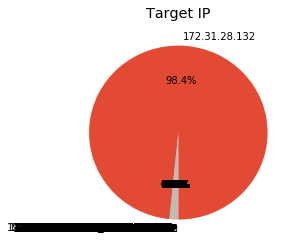

In [11]:
fig = plt.figure(figsize=(4,4))

ax = plt.subplot2grid((1,1), (0,0))
ip_dst.plot(ax=ax,kind='pie', autopct='%1.1f%%', startangle=270, fontsize=10,title="Target IP")
ax.set_ylabel("")

fig.show()

## 1.3. IP which received most packets

In [12]:
top1_target_ip=ip_dst.index[0]
top1_target_ip

'172.31.28.132'

## 2.1. Which \16 network the target IP bellongs?

In [13]:
target_network=top1_target_ip.split('.')[0]+'.'+top1_target_ip.split('.')[1]
target_network

'172.31'

## 3.1. Which IP protocols occurred more in the trace?

In [14]:
ip_proto=df['ip.proto'].value_counts()
ip_proto.head()

17      120350
1,17      1878
1            4
6            1
Name: ip.proto, dtype: int64

## 3.2. Visualizing the distribution of IP protocols

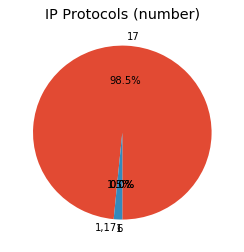

In [15]:
fig = plt.figure(figsize=(4,4))

ax = plt.subplot2grid((1,1), (0,0))
ip_proto.plot(ax=ax,kind='pie', autopct='%1.1f%%', startangle=270, fontsize=10,title="IP Protocols (number)")
ax.set_ylabel("")

fig.show()

## 3.3. Well, the IP protocol that occurred more was... 

In [16]:
top1_target_ip_proto=ip_proto.index[0]
top1_target_ip_proto

'17'

## 4.1. How is the Distribution of UDP ports for the top 1 (or 2) target IP address(es)?

In [18]:
udp_srcip_dstip_top1=df[df['ip.dst']==top1_target_ip]['ip.src'].value_counts()
udp_srcport_top1=df[df['ip.dst']==top1_target_ip]['udp.srcport'].value_counts()
udp_dstport_top1=df[df['ip.dst']==top1_target_ip]['udp.dstport'].value_counts()

udp_srcip_dstip_top1
# udp_srcip_dstip_top2=df[df['ip.dst']==top2_target_ip]['ip.src'].value_counts()
# udp_srcport_top2=df[df['ip.dst']==top2_target_ip]['udp.srcport'].value_counts()
# udp_dstport_top2=df[df['ip.dst']==top2_target_ip]['udp.dstport'].value_counts()

37.123.96.179      11126
61.93.9.158         8086
121.32.89.198       6261
89.228.8.86         4831
189.90.244.42       4433
122.154.73.42       3858
60.250.159.61       3842
180.180.126.177     3632
113.161.106.4       3305
200.107.235.46      3268
59.154.53.77        3118
109.184.1.96        2905
61.7.231.225        2806
177.69.215.97       2773
217.118.186.54      2657
92.103.90.30        2642
113.161.106.6       2601
81.7.86.91          2458
175.138.61.51       2426
110.77.140.17       2126
85.93.44.161        2109
113.161.106.2       2105
211.138.248.108     2049
218.216.183.36      2044
80.51.214.183       2042
88.85.171.248       2030
59.46.49.50         1978
109.161.52.1        1843
217.15.140.158      1685
63.246.239.2        1413
                   ...  
62.219.141.161       347
92.50.0.243          335
62.219.208.81        318
178.21.237.130       302
42.112.208.60        239
110.170.116.9        232
118.70.197.32        198
174.46.39.31         180
78.189.16.152        177


## 4.2. Visualizing the distribution of src IPs and the (src and dst) UDP ports

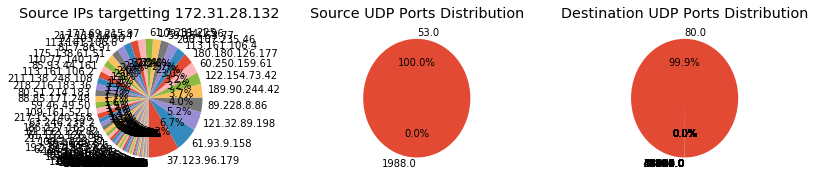

In [16]:
fig = plt.figure(figsize=(12,6))
fig.subplots_adjust(wspace=1)

ax = plt.subplot2grid((2,3), (0,0))
udp_srcip_dstip_top1.plot(kind='pie',ax=ax, autopct='%1.1f%%', startangle=270, fontsize=10,title="Source IPs targetting "+top1_target_ip)
ax.set_ylabel("")

ax1 = plt.subplot2grid((2,3), (0,1))
udp_srcport_top1.plot(kind='pie',ax=ax1, autopct='%1.1f%%', startangle=270, fontsize=10,title="Source UDP Ports Distribution")
ax1.set_ylabel("")

ax2 = plt.subplot2grid((2,3), (0,2))
udp_dstport_top1.plot(kind='pie',ax=ax2, autopct='%1.1f%%', startangle=270, fontsize=10,title="Destination UDP Ports Distribution")
ax2.set_ylabel("")

# ax3 = plt.subplot2grid((2,3), (1,0))
# udp_srcip_dstip_top2.plot(kind='pie',ax=ax3, autopct='%1.1f%%', startangle=270, fontsize=10,title="Source IPs targetting "+top2_target_ip)
# ax3.set_ylabel("")

# ax4 = plt.subplot2grid((2,3), (1,1))
# udp_srcport_top2.plot(kind='pie',ax=ax4, autopct='%1.1f%%', startangle=270, fontsize=10,title="Source UDP Ports Distribution")
# ax4.set_ylabel("")

# ax5 = plt.subplot2grid((2,3), (1,2))
# udp_dstport_top2.plot(kind='pie',ax=ax5, autopct='%1.1f%%', startangle=270, fontsize=10,title="Destination UDP Ports Distribution")
# ax5.set_ylabel("")

fig.show()

<h1 align='center'> !!!!!!!!!!!!!!!!!!!!!!!!<br>
DO THE FOLLOWING ONLY IF THE TOP SRC PORT WAS 53 (DNS)</h1>

## 5.1. What were the DNS queries used in the attack?

In [35]:
occurrence_dnsquery=df['dns.qry.name'].value_counts()
occurrence_dnsquery.head()

bls.gov         24374
nlhosting.nl    17918
sandia.gov      15805
isc.org         12504
verisign.com    10500
Name: dns.qry.name, dtype: int64

## 5.2. Visualizing the distribution of DNS queries

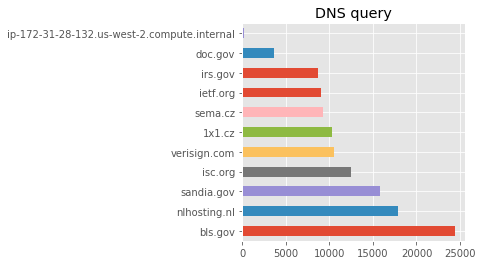

In [18]:
fig = plt.figure(figsize=(4,4))
ax = plt.subplot2grid((1,1), (0,0))
occurrence_dnsquery.plot(kind='barh',ax=ax, fontsize=10, title="DNS query")
ax.set_ylabel("")

fig.show()

## 5.3. Well, considering that only the top 1 DNS query was used in the attack... 

In [19]:
top_dnsquery=occurrence_dnsquery.index[0]
top_dnsquery

'bls.gov'

## 6.1. What was the greatest frame length that the DNS query used on the attack had? (i.e., which generated the greatest amplification factor)

In [20]:
max(df['frame.len'][df['dns.qry.name']==top_dnsquery])

31656

<h1 align='center'> !!!!! 7.1. VERY IMPORTANT !!!!!<br>
Defining ONLY the main attack records<br>(attention to the others commented types of attacks)</h1>

In [21]:
# MANUAL SELECTION: Considering the attack from ONE to ONE port!!!
attack_records=df[df['ip.dst']==top1_target_ip]\
                [df['ip.src'].str.contains(target_network)==False]\
                [df['ip.proto']==top1_target_ip_proto]\
                [df['udp.srcport']==udp_srcport_top1.index[0]]\
                [df['udp.dstport']==udp_dstport_top1.index[0]]

# # MANUAL SELECTION: Considering the attack from ONE to MANY ports!!!
# attack_records=df[df['ip.dst']==top1_target_ip]\
#                 [df['ip.src'].str.contains(target_network)==False]\
#                 [df['ip.proto']==top1_target_ip_proto]\
#                 [df['udp.srcport']==udp_srcport_top1.index[0]]\
#                 [df['dns.qry.name'].str.contains(top_dnsquery)==True]
                
# # MANUAL SELECTION: Considering the attack from MANY to ONE port!!!
# attack_records=df[df['ip.dst']==top1_target_ip]\
#                 [df['ip.src'].str.contains(target_network)==False]\
#                 [df['ip.proto']==top1_target_ip_proto]\
#                 [df['udp.dstport']==udp_dstport_top1.index[0]]\
#                 [df['dns.qry.name'].str.contains(top_dnsquery)==True]

# # MANUAL SELECTION: Considering the attack from MANY to MANY portS!!!
# attack_records=df[df['ip.dst']==top1_target_ip]\
#                 [df['ip.src'].str.contains(target_network)==False]\
#                 [df['ip.proto']==top1_target_ip_proto]\
#                 [df['udp.srcport']==udp_srcport_top1.index[0]]\
#                 [df['udp.dstport']==udp_dstport_top1.index[0]]\
#                 [df['dns.qry.name'].str.contains(top_dnsquery)==True]

remaining_records=df[~df.isin(attack_records)]


## 8.1. Generating a time series of the attack and the remaining traffic

In [22]:
overall_bps=df.set_index(['frame.time_epoch']).groupby(pd.TimeGrouper(freq='S')).agg(['sum'])['frame.len']
attack_bps=attack_records.set_index(['frame.time_epoch']).groupby(pd.TimeGrouper(freq='S')).agg(['sum'])['frame.len']
attack_bps_median=attack_bps.median()
attack_bps_peak=max(attack_bps['sum'])

remaining_bps=remaining_records.set_index(['frame.time_epoch']).groupby(pd.TimeGrouper(freq='S')).agg(['sum'])['frame.len']

## 8.2. Visualizing the time series 

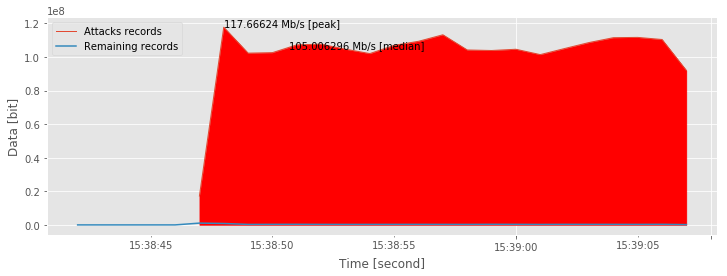

In [23]:
fig = plt.figure(figsize=(12,4))

ax = plt.subplot2grid((1,1), (0,0))

attack_bps.plot(ax=ax, lw=1)
ax.fill_between(attack_bps.index, 0, attack_bps['sum'],color='r')

ax.annotate(str(attack_bps_peak/10e5)+' Mb/s [peak]', (str(attack_bps[attack_bps['sum'] == attack_bps_peak].index.values[0]), attack_bps_peak),
             xytext=(0, 0), textcoords='offset points')
ax.annotate(str(attack_bps_median[0]/10e5)+' Mb/s [median]', (str(attack_bps.index.values[0]), attack_bps_median),
             xytext=(90, 0), textcoords='offset points')

remaining_bps.plot(ax=ax)

ax.legend(['Attacks records','Remaining records'])
ax.set_ylabel("Data [bit]")
ax.set_xlabel("Time [second]")

fig.show()

## 9.1. How many records in the entire trace, attack records, and remaining records? 

In [24]:
print 'Records:', len(df),'records (100%),',len(attack_records),'attack records (',len(attack_records)*100/len(df),'%)',',', len(df)-len(attack_records),'remaining records (',(len(df)-len(attack_records))*100/len(df),'% )'

SyntaxError: invalid syntax (<ipython-input-24-6babf1fd8156>, line 1)

## 10.1. What is the duration of the entire trace and the attack part? 

In [25]:
print 'Trace duration:',max(df['frame.time_epoch'])-min(df['frame.time_epoch'])
print 'Attack duration:',max(attack_records['frame.time_epoch'])-min(attack_records['frame.time_epoch'])

SyntaxError: invalid syntax (<ipython-input-25-a6984f19f72e>, line 1)

## 11.1. How many (source) IPs were involved in the attack?

In [26]:
len(attack_records['ip.src'].unique())

79

## 12.1. What are the top 5 IP addresses that sent more packets?

In [27]:
top5_srcips_pkts=attack_records['ip.src'].value_counts().head(5).sort_values()
top5_srcips_pkts

189.90.244.42     4433
89.228.8.86       4831
121.32.89.198     6261
61.93.9.158       8086
37.123.96.179    11126
Name: ip.src, dtype: int64

## 12.2. Visualizing the top 5 IP addresses that sent more packets

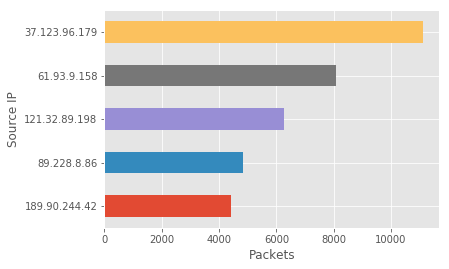

In [28]:
fig = plt.figure()
ax = plt.subplot2grid((1,1), (0,0))
top5_srcips_pkts.plot(kind='barh')
ax.set_ylabel("Source IP")
ax.set_xlabel("Packets")

fig.show()

## 13.1. What are the top 5 IP addresses that sent more attack data?

In [29]:
top5_srcips_bits=attack_records.groupby('ip.src').agg(['sum'])['frame.len'].sort_values('sum',ascending=False).head(5).sort_values('sum', ascending=False)
top5_srcips_bits

,sum
ip.src,
37.123.96.179,290276352
61.93.9.158,196340544
121.32.89.198,114598400
189.90.244.42,106533112
60.250.159.61,89142944


## 13.2. Visualizing the top 5 IP addresses that sent more attack data

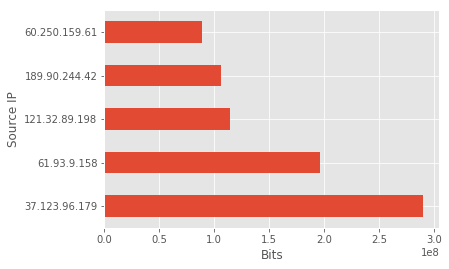

In [30]:
fig = plt.figure()
ax = plt.subplot2grid((1,1), (0,0))
top5_srcips_bits.plot(kind='barh',ax=ax,legend=False)
ax.set_ylabel("Source IP")
ax.set_xlabel("Bits")

fig.show()

## 13.3. Well, the top 1 Source IP was ...

In [31]:
top1_srcips_bits = top5_srcips_bits.index[0]
top1_srcips_bits 

'37.123.96.179'

## 14.1. In which country the top 1 source IP address is located?

In [32]:
import subprocess
p = subprocess.Popen(['whois', '-h', 'whois.cymru.com','\"', '-v',top1_srcips_bits,'\"' ], stdout=subprocess.PIPE)

p.communicate()[0]

SyntaxError: invalid syntax (<ipython-input-32-68553201aa08>, line 4)